In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# Fingerprinting Assignment
- tweets.csv의 'text'열로 LsiModel 만들어서 핑거프린팅하기
- 전처리는 트위터인걸 고려해서 맞춰서

In [ ]:
PATH = "/content/drive/MyDrive/01. Programming/Practical NLP/data/Week 18/Tweets.csv"
df = pd.read_csv(PATH)
texts = df['text'].tolist()
texts

In [ ]:
from nltk.tokenize import TweetTokenizer

tweet_tokenizer = TweetTokenizer()

texts_tokenized = [tweet_tokenizer.tokenize(sent) for sent in texts]
tokens = [[word for word in line if word not in stop_words and word.isalnum()] for line in texts_tokenized]   # 14640

In [ ]:
frequency = [Counter(sent) for sent in tokens]
dictionary = Dictionary(tokens)
bow = [dictionary.doc2bow(line) for line in tokens] 

In [ ]:
NUM_TOPICS = 2   # for modeling, matplot

tfidf_model = models.TfidfModel(bow, normalize=True)
lsa_model = models.LsiModel(bow,   # -> 그냥 넣고자 할 때
                            num_topics=NUM_TOPICS,
                            id2word=dictionary)
lsa_model.print_topics()

[(0,
  '0.894*"I" + 0.297*"flight" + 0.121*"get" + 0.090*"Cancelled" + 0.057*"time" + 0.055*"need" + 0.051*"Flight" + 0.050*"service" + 0.049*"help" + 0.049*"2"'),
 (1,
  '0.829*"flight" + -0.386*"I" + 0.250*"Cancelled" + 0.136*"Flightled" + 0.082*"get" + 0.082*"Flight" + 0.081*"delayed" + 0.061*"hours" + 0.058*"Flighted" + 0.057*"2"')]

@VirginAmerica why can't we book seats on your flights when we buy them or even during check in? Creates so much anxiety! #frustrated


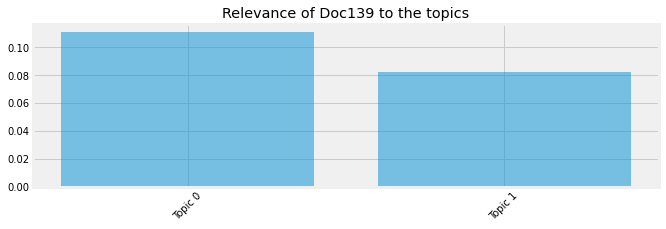

In [ ]:
def get_fingerprinting(idx):
  print(texts[idx])

  relevance = lsa_model[bow[idx]][0][1], lsa_model[bow[idx]][1][1]
  size = NUM_TOPICS

  plt.figure(figsize=(10, 3))
  ax = plt.bar(
      range(size),
      relevance,   # 그릴 것
      linewidth = 1,
      alpha = 0.5
  )
  plt.xticks(np.arange(size),
            [f'Topic {i}' for i in range(size)],
            fontsize=10,
            rotation=45)

  plt.title(f"Relevance of Doc{idx} to the topics")
  plt.show()

get_fingerprinting(139)

# Harry Potter Assignment
Task:

1. 전처리

2. 각 책마다 most frequent word -> sns barplot 으로 그리기 

3. word representation 만들기 (나는 word2vec)

4. 시각화
- tsne로 2차원 scatter plot에 그리기
- SVD 토픽 수 2개로 줄여서 scatter plot으로 그리기
- 원하는 인물 5명 골라서 벡터를 bar plot으로 그리기

5. 모델, dictionary 저장하기

 

## 1. 전처리

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

from nltk.corpus import stopwords
from keras.preprocessing.text import text_to_word_sequence

PATH = "/content/drive/MyDrive/01. Programming/Practical NLP/data/Week 18/"
stopwords = stopwords.words('english')

def open_book(num):
  with open(PATH + "HPBook" + str(num) + ".txt", "r") as f:
    text = f.read()
  
  # 간단한 전처리
  text = text.replace("\n", "")
  text = text_to_word_sequence(text)
  return text

books = [open_book(i) for i in range(1, 8)]

# 추가 전처리: 불용어 제거, 쓸데없는 기호 재거, single-character 단어 제거
books = [[word for word in book if word not in stopwords \
          and word.isalnum() \
          and word.isalpha() \
          and len(word) > 1] for book in books]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 2. 각 책마다 most frequent word -> sns barplot 으로 그리기

In [ ]:
frequencies[0]

[('harry', 1534),
 ('said', 794),
 ('potter', 434),
 ('stone', 422),
 ('ron', 405),
 ('page', 349),
 ('philosophers', 347),
 ('rowling', 347),
 ('hagrid', 331),
 ('back', 259)]

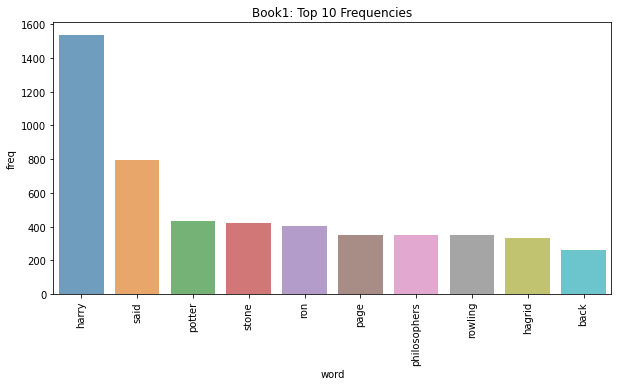

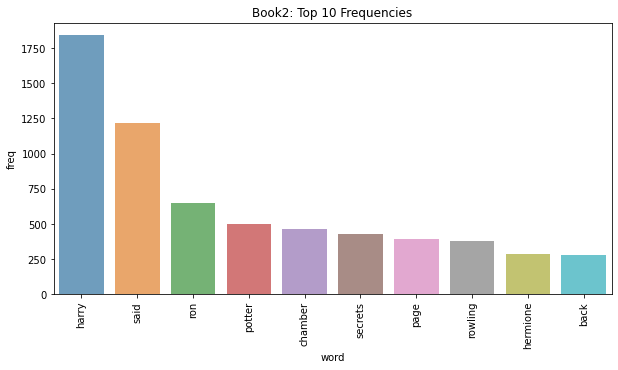

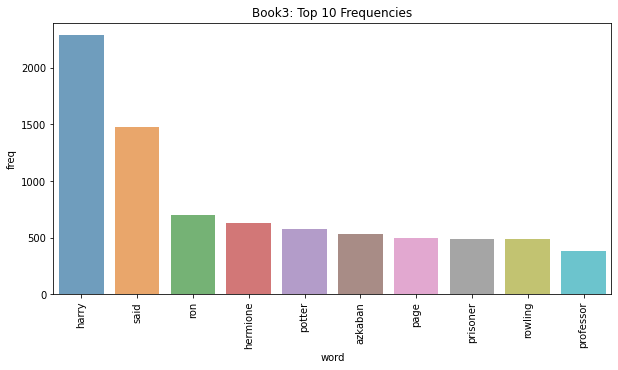

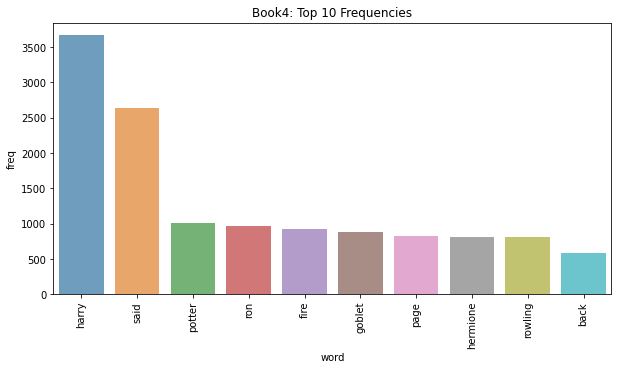

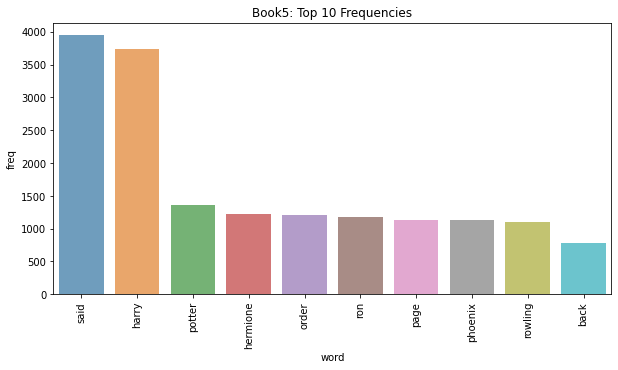

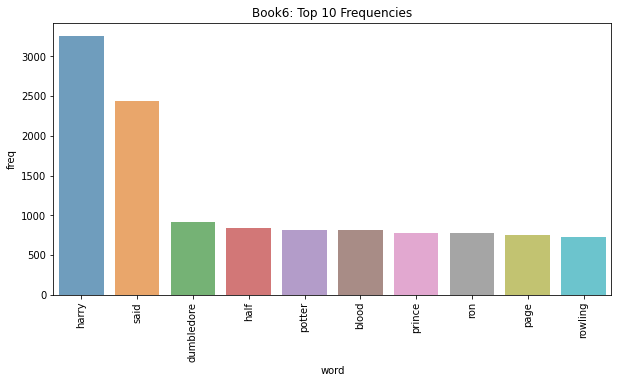

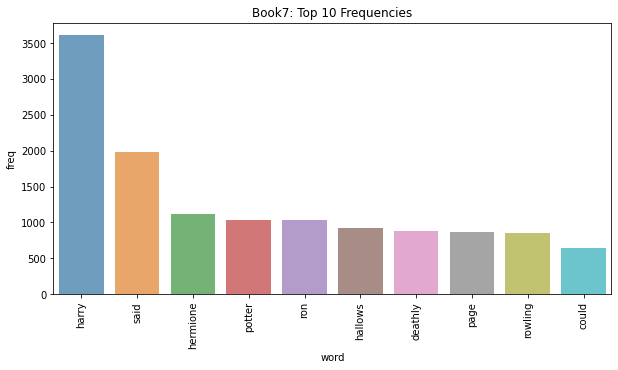

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

frequencies = [nltk.FreqDist(book).most_common(10) for book in books]

for i in range(len(frequencies)):
  df = pd.DataFrame(frequencies[i], columns=['word', 'freq'])
  fig, ax = plt.subplots(figsize=(10, 5))
  sns.barplot(x='word', y='freq', data=df, ax=ax, alpha=0.7)
  plt.xticks(rotation='vertical')
  plt.title(f"Book{i+1}: Top 10 Frequencies")
  plt.show()


## 3. word representation 만들기 (나는 word2vec)

In [ ]:
from gensim.models import Word2Vec
from gensim.parsing.preprocessing import remove_stopwords
from gensim.utils import simple_preprocess

In [ ]:
model = Word2Vec(books,
                 size=100,
                 window=5,
                 min_count=2,   # 최소 빈도수
                 workers=10,
                 sg=1   # 0=cbow, 1=skip-gram)
                )

model.init_sims(replace=True)   # 불필요한 메모리 제거

## 4. 시각화
- tsne로 2차원 scatter plot에 그리기
- SVD 토픽 수 2개로 줄여서 scatter plot으로 그리기
- 원하는 인물 5명 골라서 벡터를 bar plot으로 그리기

### 4.1. tsne로 2차원 scatter plot에 그리기

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


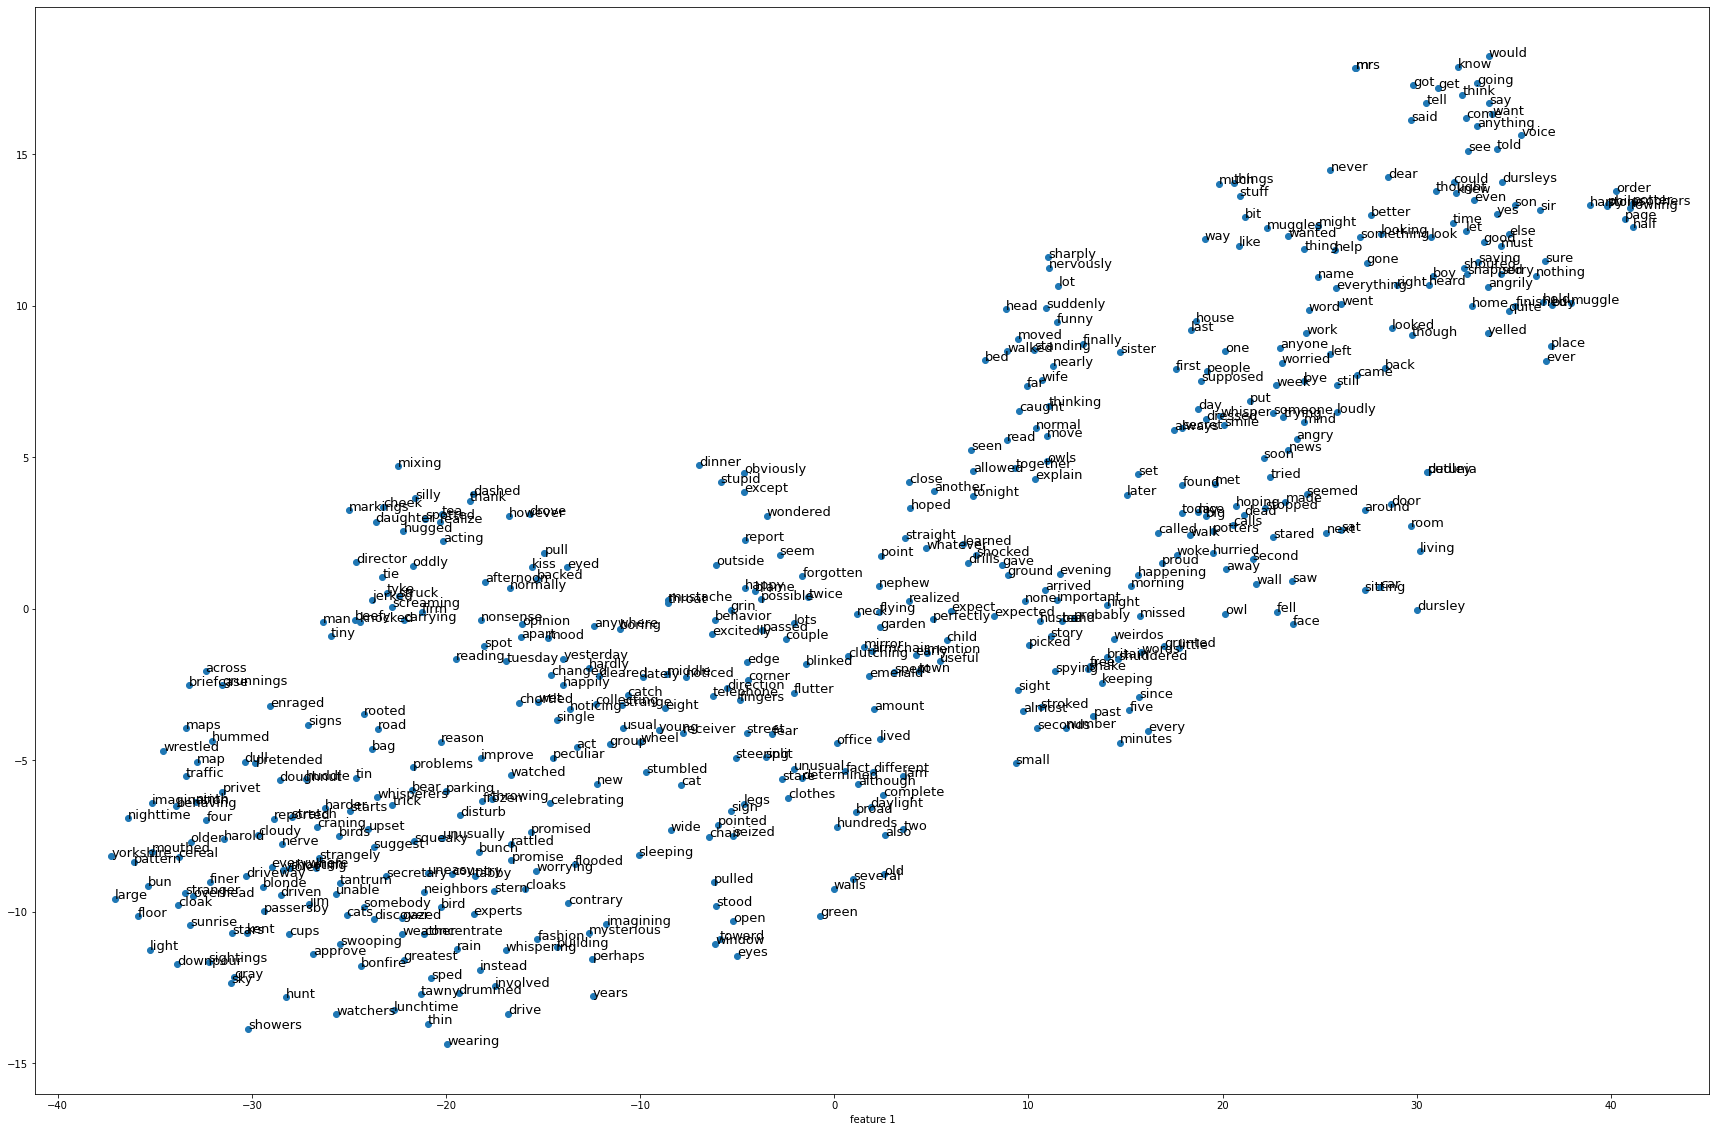

In [ ]:
from sklearn.manifold import TSNE

def draw_tsne(model:Word2Vec, vocab_size):

  vocab = list(model.wv.vocab)
  vector = model.wv[vocab]
  vocab_show = vocab[:vocab_size]
  vector_show = vector[:vocab_size, :]

  tsne = TSNE()
  X = tsne.fit_transform(vector_show)

  df = pd.DataFrame(X, index=vocab_show, columns=['x', 'y'])
  
  fig = plt.figure()
  fig.set_size_inches(30, 20)
  ax = fig.add_subplot(1, 1, 1)
  ax.scatter(df.x, df.y)

  # annotation
  for word, vector in df.iterrows():
    ax.annotate(word, vector, fontsize=13)
  
  plt.xlabel("feature 0")
  plt.ylabel("feature 1")
  plt.show()

draw_tsne(model, 500)


### 4.2. SVD 토픽 수 2개로 줄여서 scatter plot으로 그리기

In [ ]:
from sklearn.utils.extmath import randomized_svd
vocab = list(model.wv.vocab)
vector = model.wv[vocab]
vector_show = vector[:500, :]

u, s, vt = randomized_svd(vector_show, n_components=2, n_iter=3, random_state=0)
u.shape

(500, 2)

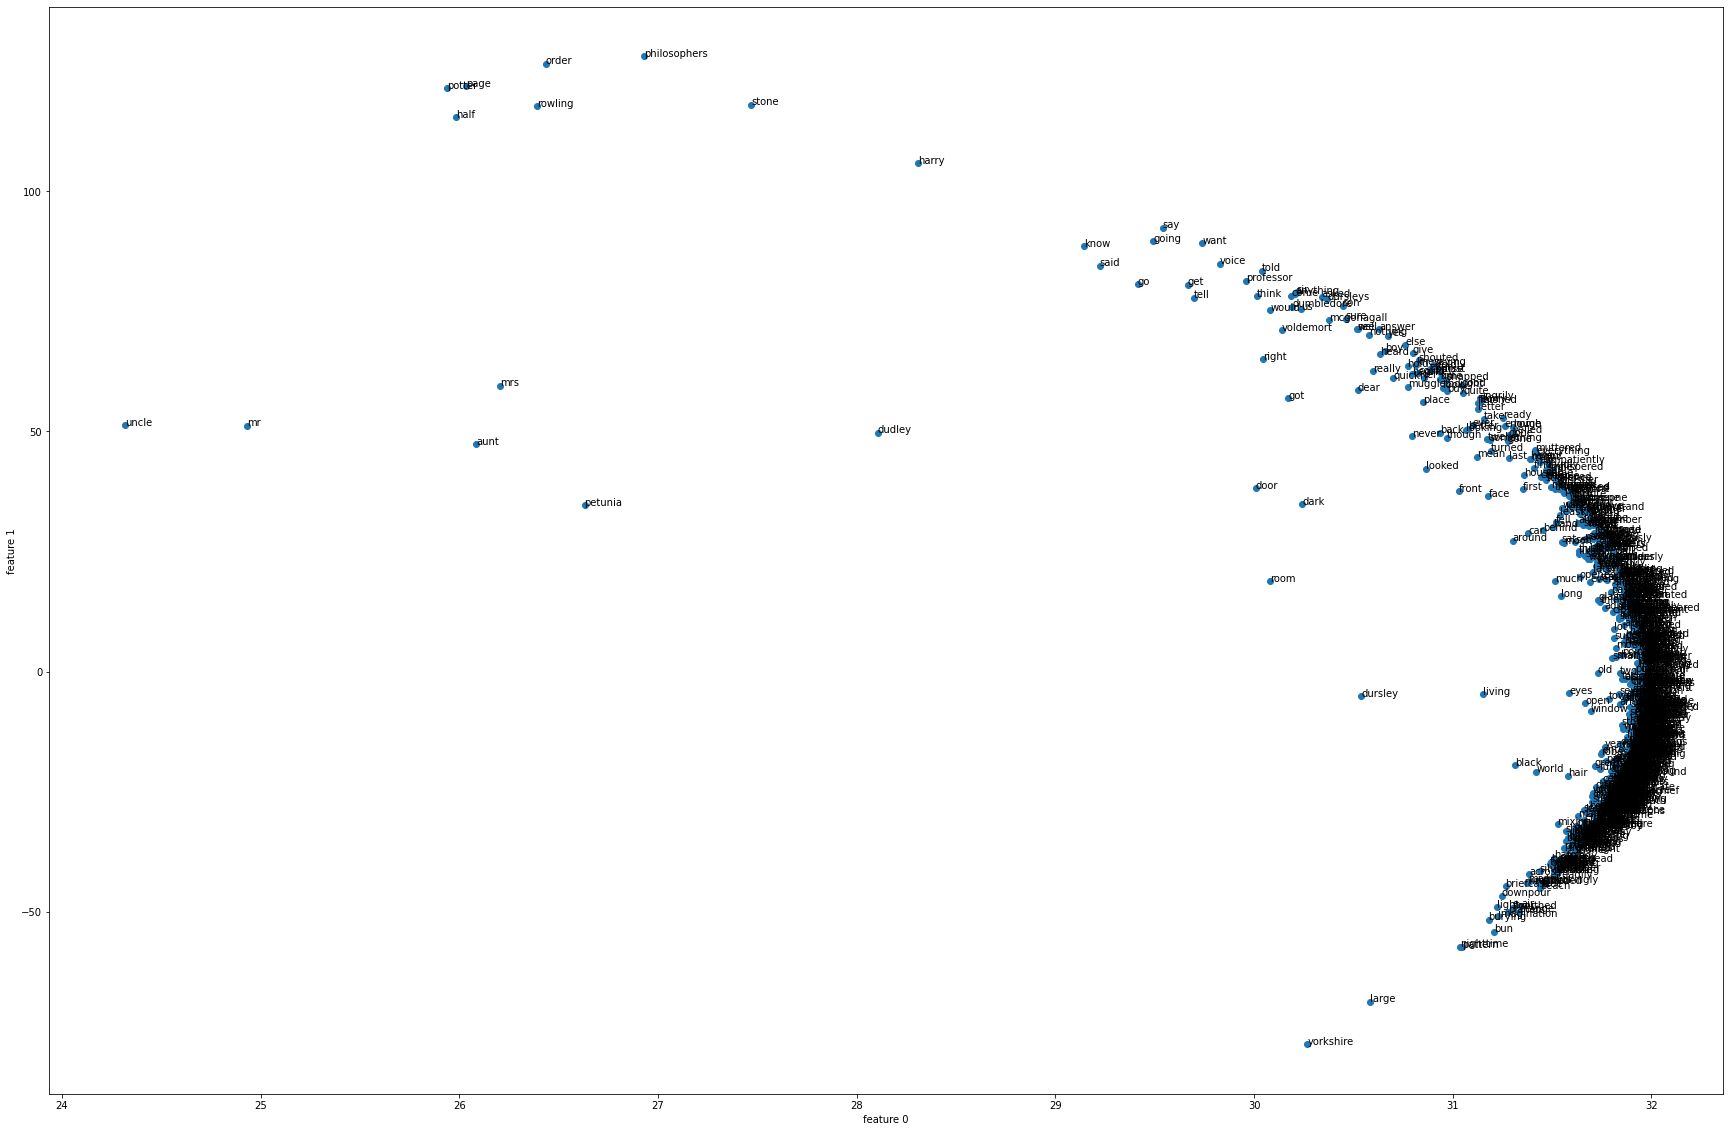

In [ ]:
from sklearn.utils.extmath import randomized_svd

u, s, vt = randomized_svd(vector.T, n_components=2, n_iter=3, random_state=0)
u.shape


def draw_svd(model:Word2Vec, vocab_size):

  vocab = list(model.wv.vocab)
  vector = model.wv[vocab]
  vocab_show = vocab[:vocab_size]
  vector_show = vector[:vocab_size, :]

  u, s, vt = randomized_svd(vector_show, n_components=2, n_iter=3, random_state=0)
  u = u * 1000
  df = pd.DataFrame(u, index=vocab_show, columns=['x', 'y'])
  
  fig = plt.figure()
  fig.set_size_inches(30, 20)
  ax = fig.add_subplot(1, 1, 1)
  ax.scatter(df.x, df.y)

  # annotation
  for word, vector in df.iterrows():
    ax.annotate(word, vector, fontsize=10)
  
  plt.xlabel("feature 0")
  plt.ylabel("feature 1")
  plt.show()

draw_svd(model, 1000)

### 4.3. 원하는 인물 5명 골라서 벡터를 bar plot으로 그리기

==Word: harry==


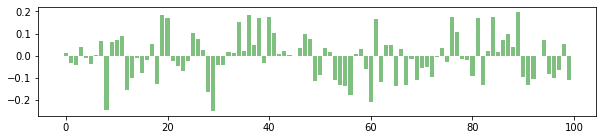

==Word: ron==


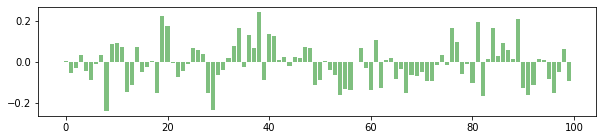

==Word: hermione==


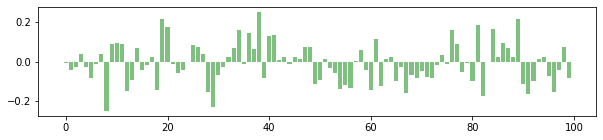

==Word: voldemort==


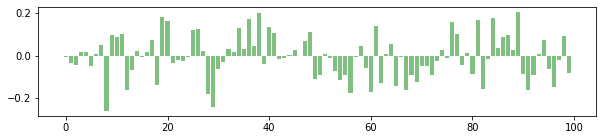

==Word: malfoy==


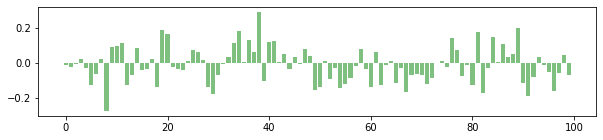

In [ ]:
import matplotlib.pyplot as plt
plt.style.use("seaborn-deep")
%matplotlib inline

def draw_vector(model:Word2Vec, word):
  vector = model.wv[word]   # 100d np array
  fig, ax = plt.subplots(1, 1, figsize=(10, 2))
  ax.tick_params(axis='both')
  ax.grid(False)
  ax.bar(range(len(vector)), vector, alpha=0.5, color='g')
  print(f"==Word: {word}==")
  plt.show()

characters = "harry ron hermione voldemort malfoy".split()
for character in characters:
  draw_vector(model, character)

## 5. 모델, dictionary 저장하기

In [ ]:
# lsa를 쓰지 않아 dictionary를 따로 만들지 않아서, 모델만 저장하겠습니다!

model.save('/content/harry_porter_word2vec.model')
try:
  model = Word2Vec.load('/content/harry_porter_word2vec.model')
except:
  print('model import failure')